In [1]:
# 必要なライブラリのimport
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')

import lightgbm as lgb
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder


import warnings
warnings.filterwarnings('ignore')

import datetime
import datetime as dt

In [2]:
# 訓練データの読み込み
# load train_df.csv
train_df = pd.read_csv('/kaggle/input/prediction-of-factory-electric-consumption/train_df.csv')

# カラム"date"を、datetime型に変換
train_df['Date'] = pd.to_datetime(train_df['Date'])

# 確認
print(f'train_df.shape = {train_df.shape}')
train_df

train_df.shape = (13872, 8)


,Date,Electric_Consumption,Factor_A,Factor_B,Factor_C,Factor_D,Factor_E,Factor_F
0,2023-01-01 00:00:00,0.000000,1.242130,28.419739,13.720397,79.840600,0.0,2.386157
1,2023-01-01 01:00:00,0.000000,1.861285,29.840759,12.537668,86.424903,0.0,1.473256
2,2023-01-01 02:00:00,0.000000,4.212674,32.778036,9.408667,72.082793,0.0,1.583711
3,2023-01-01 03:00:00,0.000000,4.025251,32.624700,9.035601,73.825705,0.0,1.706656
4,2023-01-01 04:00:00,-0.000267,3.122659,31.931245,9.235502,66.823956,0.0,0.987048
...,...,...,...,...,...,...,...,...
13867,2024-07-31 19:00:00,0.000000,2.491126,26.721779,20.921283,281.792097,0.0,1.962129
13868,2024-07-31 20:00:00,0.000000,2.188116,26.154546,22.515901,270.805807,0.0,1.917802
13869,2024-07-31 21:00:00,0.000000,1.668992,24.493361,25.172410,293.789724,0.0,2.478379
13870,2024-07-31 22:00:00,0.000000,1.320810,21.270959,30.349866,246.840110,0.0,2.520926


In [3]:
# 予測対象データの読み込み
# load test_df.csv
test_df = pd.read_csv('/kaggle/input/prediction-of-factory-electric-consumption/test_df.csv')

# カラム"date"を、datetime型に変換
test_df['Date'] = pd.to_datetime(test_df['Date'])

# 確認
print(f'test_df.shape = {test_df.shape}')
test_df

test_df.shape = (2160, 7)


,Date,Factor_A,Factor_B,Factor_C,Factor_D,Factor_E,Factor_F
0,2024-08-01 00:00:00,1.775026,21.729808,24.808146,249.474701,0.00,1.808403
1,2024-08-01 01:00:00,2.176429,20.792287,25.128845,241.233210,0.00,1.847753
2,2024-08-01 02:00:00,2.644089,20.041586,25.045506,239.540034,0.00,1.967446
3,2024-08-01 03:00:00,2.759897,18.551710,26.976024,238.425577,0.00,2.128126
4,2024-08-01 04:00:00,2.670419,16.689420,29.611734,240.139421,0.00,1.945275
...,...,...,...,...,...,...,...
2155,2024-10-29 19:00:00,4.681367,28.499568,38.240114,196.742042,0.40,8.280931
2156,2024-10-29 20:00:00,3.703966,21.099590,78.749413,231.312809,0.40,2.184659
2157,2024-10-29 21:00:00,1.772623,21.571307,73.936977,261.595582,0.40,1.398882
2158,2024-10-29 22:00:00,2.264330,22.906498,65.452700,202.245441,0.40,1.330848


In [4]:
# Submissionファイルの読み込み
# load submission.csv
submission = pd.read_csv('/kaggle/input/prediction-of-factory-electric-consumption/submission.csv')

# 確認
print(f'submission.shape = {submission.shape}')
submission

submission.shape = (2160, 2)


,Date,Electric_Consumption
0,2024-08-01 00:00:00,0
1,2024-08-01 01:00:00,0
2,2024-08-01 02:00:00,0
3,2024-08-01 03:00:00,0
4,2024-08-01 04:00:00,0
...,...,...
2155,2024-10-29 19:00:00,0
2156,2024-10-29 20:00:00,0
2157,2024-10-29 21:00:00,0
2158,2024-10-29 22:00:00,0


In [5]:
# ーーーー 特徴量エンジニアリング ーーーー
# 以下、必要に応じて、特徴量生成等を行う。

In [6]:
# 例えば、特徴量生成
# Dateから、時系列に関する変数を生成したり・・・・
# 数値変数から、例えば、1/変数　等の新たな変数を生成したり・・・

今回は、datetime型の変数である'date'から、年・月・日・時間 の特徴量を生成してみましょう。

In [7]:
# Dateから、year, month, day, hourの情報を生成
# 訓練データ

train_df['day'] = train_df['Date'].dt.day
train_df['hour'] = train_df['Date'].dt.hour
train_df['date'] = train_df['Date'].map(lambda x: x.weekday())
#train_df['new'] = train_df['Factor_F']*train_df['hour']
train_df['ff'] = train_df['Factor_F']*train_df['Factor_F']

# 予測対象データ

test_df['day'] = test_df['Date'].dt.day
test_df['hour'] = test_df['Date'].dt.hour
test_df['date'] = test_df['Date'].map(lambda x: x.weekday())
#test_df['new'] = test_df['Factor_F']*test_df['hour']
test_df['ff'] = test_df['Factor_F']*test_df['Factor_F']

# 表示
display(train_df)
display(test_df)

,Date,Electric_Consumption,Factor_A,Factor_B,Factor_C,Factor_D,Factor_E,Factor_F,day,hour,date,ff
0,2023-01-01 00:00:00,0.000000,1.242130,28.419739,13.720397,79.840600,0.0,2.386157,1,0,6,5.693745
1,2023-01-01 01:00:00,0.000000,1.861285,29.840759,12.537668,86.424903,0.0,1.473256,1,1,6,2.170484
2,2023-01-01 02:00:00,0.000000,4.212674,32.778036,9.408667,72.082793,0.0,1.583711,1,2,6,2.508141
3,2023-01-01 03:00:00,0.000000,4.025251,32.624700,9.035601,73.825705,0.0,1.706656,1,3,6,2.912675
4,2023-01-01 04:00:00,-0.000267,3.122659,31.931245,9.235502,66.823956,0.0,0.987048,1,4,6,0.974264
...,...,...,...,...,...,...,...,...,...,...,...,...
13867,2024-07-31 19:00:00,0.000000,2.491126,26.721779,20.921283,281.792097,0.0,1.962129,31,19,2,3.849952
13868,2024-07-31 20:00:00,0.000000,2.188116,26.154546,22.515901,270.805807,0.0,1.917802,31,20,2,3.677963
13869,2024-07-31 21:00:00,0.000000,1.668992,24.493361,25.172410,293.789724,0.0,2.478379,31,21,2,6.142363
13870,2024-07-31 22:00:00,0.000000,1.320810,21.270959,30.349866,246.840110,0.0,2.520926,31,22,2,6.355069


,Date,Factor_A,Factor_B,Factor_C,Factor_D,Factor_E,Factor_F,day,hour,date,ff
0,2024-08-01 00:00:00,1.775026,21.729808,24.808146,249.474701,0.00,1.808403,1,0,3,3.270320
1,2024-08-01 01:00:00,2.176429,20.792287,25.128845,241.233210,0.00,1.847753,1,1,3,3.414192
2,2024-08-01 02:00:00,2.644089,20.041586,25.045506,239.540034,0.00,1.967446,1,2,3,3.870843
3,2024-08-01 03:00:00,2.759897,18.551710,26.976024,238.425577,0.00,2.128126,1,3,3,4.528919
4,2024-08-01 04:00:00,2.670419,16.689420,29.611734,240.139421,0.00,1.945275,1,4,3,3.784095
...,...,...,...,...,...,...,...,...,...,...,...
2155,2024-10-29 19:00:00,4.681367,28.499568,38.240114,196.742042,0.40,8.280931,29,19,1,68.573812
2156,2024-10-29 20:00:00,3.703966,21.099590,78.749413,231.312809,0.40,2.184659,29,20,1,4.772734
2157,2024-10-29 21:00:00,1.772623,21.571307,73.936977,261.595582,0.40,1.398882,29,21,1,1.956871
2158,2024-10-29 22:00:00,2.264330,22.906498,65.452700,202.245441,0.40,1.330848,29,22,1,1.771155


本来は、もっと色々な特徴量を生成し、試行錯誤するのがオススメです。 例えば・・・・

月日、季節、曜日データ
ラグ特徴量、Window特徴量、Expanding特徴量
スプライン特徴量
フーリエ級数
季節成分・トレンド
・・・・などなど。


ですが、このnotebookはベースラインですので、特徴量生成は最小限にとどめます。

解析結果、月は関係なさそう

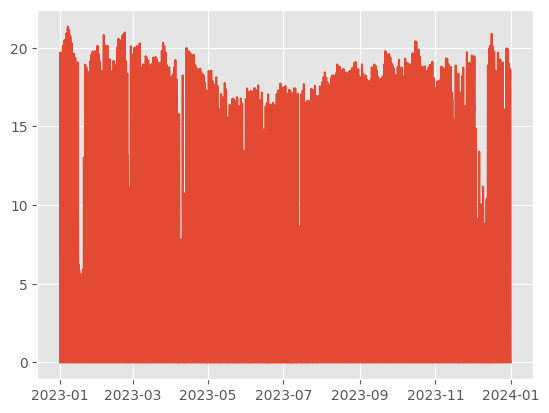

count                   8761
mean     2023-07-02 12:00:00
min      2023-01-01 00:00:00
25%      2023-04-02 06:00:00
50%      2023-07-02 12:00:00
75%      2023-10-01 18:00:00
max      2024-01-01 00:00:00
Name: Date, dtype: object


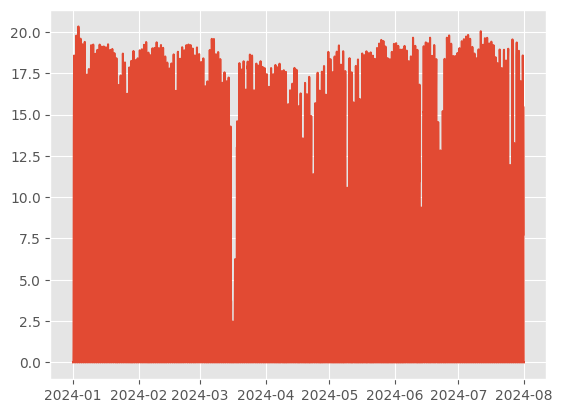

count                   5112
mean     2024-04-16 11:30:00
min      2024-01-01 00:00:00
25%      2024-02-23 05:45:00
50%      2024-04-16 11:30:00
75%      2024-06-08 17:15:00
max      2024-07-31 23:00:00
Name: Date, dtype: object


In [8]:
train_df2 = train_df
train_df2023 = train_df2[train_df2['Date'] <= dt.datetime(2024, 1, 1)]
train_df2024 = train_df2[(train_df2['Date'] >= dt.datetime(2024, 1, 1)) & (train_df2['Date'] <= dt.datetime(2025, 1, 1))]

plt.plot(train_df2023['Date'],train_df2023['Electric_Consumption'])
plt.show()
print(train_df2023['Date'].describe())

plt.plot(train_df2024['Date'],train_df2024['Electric_Consumption'])
plt.show()
print(train_df2024['Date'].describe())

In [9]:
# ーーーー　時系列考慮のHold-Out ーーーー

通常の回帰タスクでは、KFold交差検証を行う人も多いと思います。

ただ今回は、モデル訓練データと予測対象データが時系列になっています。

こういう状況で交差検証を行うと「本来は使用することができない未来のデータを使って現在のデータを予測してしまう」という・・・データのリークを引き起こしてしまいます。 それを避けるため、一番シンプルに、時系列に基づいてHold-out分割しています。

尚、scikit-learnには、TimeSeriesSplitという、時系列データ用の交差検証ライブラリも用意されています。 興味のある方は、是非、調べてみてください。

また、データが時系列順に取得されているものの、目的変数や説明変数が周期性を持たないなど・・・時系列の特徴が薄い場合は、KFold交差検証でも良い結果が得られることもあります。（個人的にはオススメしませんが）

Adversarial-testなど、訓練データと予測対象データの各変数の分布に差異が無いか等々、EDAに基づいてバリデーション設計を行なってください。

時系列データでは、特徴量エンジニアリングよりもバリデーション設計の方が重要ですので、色々なバリデーションパターンを試してみてくださいね。



訓練データ : 2023年1月1日 〜 2024年7月31日
予測データ : 2024年8月1日 〜 2024年10月29日
つまり、訓練データ → 予測対象データ という時系列順にデータが取得されています。 また、予測対象データの期間は3ヶ月です。

このような時には、どんなバリデーション設計が可能でしょうか？？

1. モデル学習期間 2023年1月1日〜2024年6月30日、検証期間 2024年7月の1ヶ月
2. モデル学習期間 2023年1月1日〜2024年4月30日、検証期間 2024年5月・6月・7月の3ヶ月（より正確に、訓練データと予測対象データの時系列に合わせる）
3. 複数のバリデーション期間を設定(※1)
※1 例えば、上記の1と2をリスト化し、各々のバリデーションに対して、モデルを複数構築し、その複数のモデルで予測対象データに対するpredictを行い、最後に平均化したりします。

今回は、2を選択します。

In [10]:
# モデル訓練用データ
# 2024年4月30日までのデータをモデル訓練用として分割
train_hold_df = train_df[(train_df['Date'] <= dt.datetime(2024,4,30))]

# 確認
print(f'train_hold_df.shape = {train_hold_df.shape}')
train_hold_df

train_hold_df.shape = (11641, 12)


,Date,Electric_Consumption,Factor_A,Factor_B,Factor_C,Factor_D,Factor_E,Factor_F,day,hour,date,ff
0,2023-01-01 00:00:00,0.000000,1.242130,28.419739,13.720397,79.840600,0.0,2.386157,1,0,6,5.693745
1,2023-01-01 01:00:00,0.000000,1.861285,29.840759,12.537668,86.424903,0.0,1.473256,1,1,6,2.170484
2,2023-01-01 02:00:00,0.000000,4.212674,32.778036,9.408667,72.082793,0.0,1.583711,1,2,6,2.508141
3,2023-01-01 03:00:00,0.000000,4.025251,32.624700,9.035601,73.825705,0.0,1.706656,1,3,6,2.912675
4,2023-01-01 04:00:00,-0.000267,3.122659,31.931245,9.235502,66.823956,0.0,0.987048,1,4,6,0.974264
...,...,...,...,...,...,...,...,...,...,...,...,...
11636,2024-04-29 20:00:00,0.000000,3.169818,15.297683,70.285937,120.888047,0.0,1.568154,29,20,0,2.459107
11637,2024-04-29 21:00:00,0.000000,3.903605,14.718142,72.511740,120.895961,0.0,1.911877,29,21,0,3.655273
11638,2024-04-29 22:00:00,0.000000,2.351327,13.974564,75.105761,121.510368,0.0,1.764252,29,22,0,3.112584
11639,2024-04-29 23:00:00,0.000000,1.780393,13.342751,76.517058,137.065847,0.0,1.854842,29,23,0,3.440440


In [11]:
# モデル検証用データ
# 2024年5月1日から、7月31日までのデータをモデル検証用として分割
valid_hold_df = train_df[(train_df['Date'] >= dt.datetime(2024,5,1)) & (train_df['Date'] <= dt.datetime(2024,7,31))]

# 確認
print(f'valid_hold_df.shape = {valid_hold_df.shape}')
valid_hold_df

valid_hold_df.shape = (2185, 12)


,Date,Electric_Consumption,Factor_A,Factor_B,Factor_C,Factor_D,Factor_E,Factor_F,day,hour,date,ff
11664,2024-05-01 00:00:00,0.0,1.039039,7.224231,78.104678,135.809069,0.0,24.741709,1,0,2,612.152188
11665,2024-05-01 01:00:00,0.0,1.309934,6.627840,80.535238,189.302223,0.0,18.591275,1,1,2,345.635523
11666,2024-05-01 02:00:00,0.0,0.860310,7.053314,78.840913,189.356146,0.0,12.440841,1,2,2,154.774535
11667,2024-05-01 03:00:00,0.0,0.791333,6.887144,78.080879,215.569681,0.0,6.290407,1,3,2,39.569225
11668,2024-05-01 04:00:00,0.0,0.790357,5.973142,82.285528,186.291450,0.0,1.678103,1,4,2,2.816031
...,...,...,...,...,...,...,...,...,...,...,...,...
13844,2024-07-30 20:00:00,0.0,2.341171,22.119577,19.832750,67.195729,0.0,1.262422,30,20,1,1.593708
13845,2024-07-30 21:00:00,0.0,2.597244,22.481908,18.601984,239.822074,0.0,1.698314,30,21,1,2.884271
13846,2024-07-30 22:00:00,0.0,2.888787,21.320026,19.731643,37.097940,0.0,2.455903,30,22,1,6.031462
13847,2024-07-30 23:00:00,0.0,3.061877,20.425678,20.318542,222.050741,0.0,1.610256,30,23,1,2.592923


In [12]:
# 学習用データの目的変数を設定
y_train_hold = train_hold_df[['Electric_Consumption']]

# 学習用データの説明変数を設定
x_train_hold = train_hold_df.drop(['Date', 'Electric_Consumption' ], axis=1)


# 検証データの目的変数を設定
y_valid_hold = valid_hold_df[['Electric_Consumption']]

# 検証データの説明変数を設定
x_valid_hold = valid_hold_df.drop(['Date', 'Electric_Consumption' ], axis=1)

# 確認
display(x_train_hold)
display(x_valid_hold)

,Factor_A,Factor_B,Factor_C,Factor_D,Factor_E,Factor_F,day,hour,date,ff
0,1.242130,28.419739,13.720397,79.840600,0.0,2.386157,1,0,6,5.693745
1,1.861285,29.840759,12.537668,86.424903,0.0,1.473256,1,1,6,2.170484
2,4.212674,32.778036,9.408667,72.082793,0.0,1.583711,1,2,6,2.508141
3,4.025251,32.624700,9.035601,73.825705,0.0,1.706656,1,3,6,2.912675
4,3.122659,31.931245,9.235502,66.823956,0.0,0.987048,1,4,6,0.974264
...,...,...,...,...,...,...,...,...,...,...
11636,3.169818,15.297683,70.285937,120.888047,0.0,1.568154,29,20,0,2.459107
11637,3.903605,14.718142,72.511740,120.895961,0.0,1.911877,29,21,0,3.655273
11638,2.351327,13.974564,75.105761,121.510368,0.0,1.764252,29,22,0,3.112584
11639,1.780393,13.342751,76.517058,137.065847,0.0,1.854842,29,23,0,3.440440


,Factor_A,Factor_B,Factor_C,Factor_D,Factor_E,Factor_F,day,hour,date,ff
11664,1.039039,7.224231,78.104678,135.809069,0.0,24.741709,1,0,2,612.152188
11665,1.309934,6.627840,80.535238,189.302223,0.0,18.591275,1,1,2,345.635523
11666,0.860310,7.053314,78.840913,189.356146,0.0,12.440841,1,2,2,154.774535
11667,0.791333,6.887144,78.080879,215.569681,0.0,6.290407,1,3,2,39.569225
11668,0.790357,5.973142,82.285528,186.291450,0.0,1.678103,1,4,2,2.816031
...,...,...,...,...,...,...,...,...,...,...
13844,2.341171,22.119577,19.832750,67.195729,0.0,1.262422,30,20,1,1.593708
13845,2.597244,22.481908,18.601984,239.822074,0.0,1.698314,30,21,1,2.884271
13846,2.888787,21.320026,19.731643,37.097940,0.0,2.455903,30,22,1,6.031462
13847,3.061877,20.425678,20.318542,222.050741,0.0,1.610256,30,23,1,2.592923


In [13]:
# LightGBM ハイパーパラメーターの設定
lgbm_params = {
    'boosting_type': 'gbdt',        # Gradient Boosting Decision Tree
    'objective': 'regression',      # 回帰タスク
    'metric': 'rmse',               # 評価指標
    
    'learning_rate': 0.04,          # デフォルトは0.1ですが、やや大きいと感じるので、数万程度のデータ数の場合は、0.02〜0.05に設定することが多いです。
    'n_estimators': 100000,         # Early-Stoppingを使いますので、大きめに設定
    'importance_type': 'gain',      # 特徴量の重要度取得用。 gainを選択した方が良いと言われています。
    
    # -- モデルの学習促進 --           大きくすると、学習は進みますが、過学習しやすくなります。
    'num_leaves': 100,               # 8〜256
    
    
    # -- モデルの過学習抑制 --         # 大きくすることで、過学習を抑制できます。
    'min_data_in_leaf': 12,         # 5〜200
    'min_sum_hessian_in_leaf': 20,  # 5〜200
    'lambda_l1': 0.0,               # 0.01〜100
    'lambda_l2': 0.0,               # 0.01〜100
    
    'bagging_fraction': 0.9,        # 小さくするほど、過学習を抑え、学習速度もあがる。
    'bagging_freq': 1,              # 1にすると、決定木作成ごとに、毎回、サンプリングが実行される。（デフォルトは0）
    'feature_fraction': 0.9,        # 小さくするほど、過学習を抑え、学習速度もあがる。

    'random_seed': 126              # 乱数設定。 数値はご自由に。
}

上記のハイパーパラメータは、適当に設定しました。

序盤では調整不要ですが、コンペも終盤に差し掛かりましたら、Optuna等で、各ハイパーパラメータの最適化も検討してみてくださいね（過学習には注意しながら）。

[LightGBM] [Warning] min_data_in_leaf is set=12, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=12
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=0.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=20, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=20
[LightGBM] [Warning] lambda_l1 is set=0.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_data_in_leaf is set=12, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=12
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_by

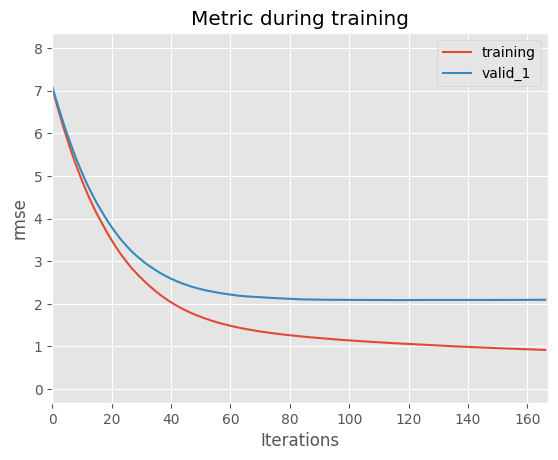

In [14]:
# LightGBMREgressor()インスタンスの生成
model = lgb.LGBMRegressor(**lgbm_params)

# verbose_evalの設定
verbose_eval = 1

# モデルのfitting
model.fit(
        x_train_hold,
        y_train_hold, 
        eval_set = [(x_train_hold, y_train_hold), (x_valid_hold, y_valid_hold)], 
        callbacks=[lgb.early_stopping(stopping_rounds=50, verbose=True),lgb.log_evaluation(verbose_eval)], 
)

# 学習曲線の描画
lgb.plot_metric(model);

まぁ、あまり意味ないかもしれませんけど・・・学習済みモデルが重視した変数を確認しましょうか。

In [15]:
# 学習済みモデルが重視した変数の確認

# 空のDataFrameを用意
imp_df = pd.DataFrame()

# 説明変数の重要度をDataFrame化
temp_imp = pd.DataFrame({
    'col': x_train_hold.columns, 
    'imp': model.feature_importances_
})
    
# 重要度のDataFrameに結合
imp_df = pd.concat(
    [imp_df, temp_imp], 
    axis=0, 
    ignore_index=True
)

# 説明変数の重要度を整形
imp_group_df = imp_df.groupby('col')['imp'].agg(['mean', ])

# カラム名の変更
imp_group_df.columns = ['imp_mean', ]

# indexをリセット
imp_group_df = imp_group_df.reset_index(drop=False)

# imp_meanでソート
imp_group_df.sort_values('imp_mean', ascending=False, ignore_index=True).loc[0:50, :]


,col,imp_mean
0,Factor_F,3.489332e+06
1,hour,1.380647e+06
2,Factor_B,1.074160e+06
3,Factor_C,3.735260e+05
4,Factor_A,3.366775e+05
5,ff,3.180845e+05
6,Factor_D,5.658876e+04
7,day,5.591657e+04
8,date,1.953250e+04
9,Factor_E,1.289767e+04


imp_meanの数値が大きい変数ほど、モデルが重視している変数です。 特徴量エンジニアリングの際に、是非、参考にしてみてください。

In [16]:
# 学習用データによるpredict
y_pred_train_hold = model.predict(x_train_hold, num_iteration=model.best_iteration_) 

# 検証用データによるpredict
y_pred_valid_hold = model.predict(x_valid_hold, num_iteration=model.best_iteration_) 

# RMSEを算出
# 学習用データ
temp_rmse_train = np.sqrt(mean_squared_error(y_train_hold, y_pred_train_hold))
    
# 検証用データ
temp_rmse_valid = np.sqrt(mean_squared_error(y_valid_hold, y_pred_valid_hold))
    
# RMSEの表示
print(f'\nRMSE(train_data) = {temp_rmse_train:.4f}')
print(f'RMSE(valid_data) = {temp_rmse_valid:.4f}\n')

[LightGBM] [Warning] min_sum_hessian_in_leaf is set=20, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=12, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=12
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=0.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0
[LightGBM] [Warning] lambda_l1 is set=0.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=20, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=1

この後、submitを行い、PublicLBのスコアを取得することになります。 その際、PublicLBのスコアと、このvalid_dataのスコアとの間に大きな乖離があった場合は、モデルがover-fittingを引き起こしている可能性が高いです。

In [17]:
# 学習済みモデルに投入する予測対象データの説明変数を設定
x_test = test_df.drop(['Date'], axis=1)

# 確認
display(x_test)

,Factor_A,Factor_B,Factor_C,Factor_D,Factor_E,Factor_F,day,hour,date,ff
0,1.775026,21.729808,24.808146,249.474701,0.00,1.808403,1,0,3,3.270320
1,2.176429,20.792287,25.128845,241.233210,0.00,1.847753,1,1,3,3.414192
2,2.644089,20.041586,25.045506,239.540034,0.00,1.967446,1,2,3,3.870843
3,2.759897,18.551710,26.976024,238.425577,0.00,2.128126,1,3,3,4.528919
4,2.670419,16.689420,29.611734,240.139421,0.00,1.945275,1,4,3,3.784095
...,...,...,...,...,...,...,...,...,...,...
2155,4.681367,28.499568,38.240114,196.742042,0.40,8.280931,29,19,1,68.573812
2156,3.703966,21.099590,78.749413,231.312809,0.40,2.184659,29,20,1,4.772734
2157,1.772623,21.571307,73.936977,261.595582,0.40,1.398882,29,21,1,1.956871
2158,2.264330,22.906498,65.452700,202.245441,0.40,1.330848,29,22,1,1.771155


In [18]:
# 予測対象用データで、実際に予測

# predict
preds_test = model.predict(x_test, num_iteration=model.best_iteration_)

# preds_testリストをNumPy配列に変換
preds_test_np = np.array(preds_test)

# 予測値から、submissionファイルを作成
submission['Electric_Consumption'] = preds_test_np

# 確認
display(submission)

[LightGBM] [Warning] min_sum_hessian_in_leaf is set=20, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=12, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=12
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=0.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0
[LightGBM] [Warning] lambda_l1 is set=0.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


,Date,Electric_Consumption
0,2024-08-01 00:00:00,0.061284
1,2024-08-01 01:00:00,0.061284
2,2024-08-01 02:00:00,0.056864
3,2024-08-01 03:00:00,0.055794
4,2024-08-01 04:00:00,0.055794
...,...,...
2155,2024-10-29 19:00:00,0.161966
2156,2024-10-29 20:00:00,0.083139
2157,2024-10-29 21:00:00,0.061706
2158,2024-10-29 22:00:00,0.059676


In [19]:
# submit submission.csv
submission.to_csv('./submission.csv', index=False)